In [734]:
%pylab inline
file_root = '/mnt/store1/oliverphilcox/DR12_QPM/output_xifinecorr/mock_16/'
jackknife_file = '/mnt/store1/oliverphilcox/DR12_QPM/xi_jack/mock_16/xi_jack_corrected_n35_m10_j169_11.dat'
weight_dir = '/mnt/store1/oliverphilcox/DR12_QPM/'
m=10
n_samples = 20

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['fmin']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [849]:
# script to post-process covariance matrices for each QPM mock + produces an npz output file 
import sys,os

xi_jack = np.loadtxt(jackknife_file,skiprows=2)
n_bins = xi_jack.shape[1] # total bins
n_jack = xi_jack.shape[0] # total jackknives
n = n_bins//m # radial bins

weight_file = weight_dir+'jackknife_weights_n%d_m%d_j%d_11.dat'%(n,m,n_jack)
RR_file = weight_dir+'binned_pair_counts_n%d_m%d_j%d_11.dat'%(n,m,n_jack)

print("Loading weights file from %s"%weight_file)
weights = np.loadtxt(weight_file)[:,1:]

# First exclude any dodgy jackknife regions
good_jk=np.unique(np.where(np.isfinite(xi_jack))[0])
print("Using %d out of %d jackknives"%(len(good_jk),n_jack))
xi_jack = xi_jack[good_jk]
weights = weights[good_jk]

# Compute data covariance matrix
print("Computing data covariance matrix")
mean_xi = np.sum(xi_jack*weights,axis=0)/np.sum(weights,axis=0)
tmp = weights*(xi_jack-mean_xi)
data_cov = np.matmul(tmp.T,tmp)
denom = np.matmul(weights.T,weights)
data_cov /= (np.ones_like(denom)-denom)

print("Loading weights file from %s"%RR_file)
RR=np.loadtxt(RR_file)

Loading weights file from /mnt/store1/oliverphilcox/DR12_QPM/jackknife_weights_n35_m10_j169_11.dat
Using 169 out of 169 jackknives
Computing data covariance matrix
Loading weights file from /mnt/store1/oliverphilcox/DR12_QPM/binned_pair_counts_n35_m10_j169_11.dat


In [736]:
def load_matrices(index,jack=True):
    """Load intermediate or full covariance matrices"""
    if jack:
        cov_root = file_root+'CovMatricesJack/'
    else:
        cov_root = file_root+'CovMatricesAll/'
    c2 = np.diag(np.loadtxt(cov_root+'c2_n%d_m%d_11_%s.txt'%(n,m,index)))
    c3 = np.loadtxt(cov_root+'c3_n%d_m%d_1,11_%s.txt'%(n,m,index))
    c4 = np.loadtxt(cov_root+'c4_n%d_m%d_11,11_%s.txt'%(n,m,index))
    if jack:
        EEaA1 = np.loadtxt(cov_root+'EE1_n%d_m%d_11_%s.txt' %(n,m,index))
        EEaA2 = np.loadtxt(cov_root+'EE2_n%d_m%d_11_%s.txt' %(n,m,index))
        RRaA1 = np.loadtxt(cov_root+'RR1_n%d_m%d_11_%s.txt' %(n,m,index))
        RRaA2 = np.loadtxt(cov_root+'RR2_n%d_m%d_11_%s.txt' %(n,m,index))

        # Compute disconnected term
        w_aA1 = RRaA1/np.sum(RRaA1,axis=0)
        w_aA2 = RRaA2/np.sum(RRaA2,axis=0)
        diff1 = EEaA1-w_aA1*EEaA1.sum(axis=0)
        diff2 = EEaA2-w_aA2*EEaA2.sum(axis=0)
        RRaRRb = np.matmul(np.asmatrix(RR).T,np.asmatrix(RR))
        fact = np.ones_like(c4)-np.matmul(np.asmatrix(weights).T,np.asmatrix(weights))
        cx = np.asarray(np.matmul(diff1.T,diff2)/np.matmul(fact,RRaRRb))
        c4+=cx

    # Now symmetrize and return matrices
    return c2,0.5*(c3+c3.T),0.5*(c4+c4.T)

# Load in full jackknife theoretical matrices
print("Loading best estimate of jackknife covariance matrix")
c2,c3,c4=load_matrices('full')

# Load in partial jackknife theoretical matrices
c2s,c3s,c4s=[],[],[]
for i in range(n_samples):
    #print("Loading jackknife subsample %d of %d"%(i+1,n_samples))
    cc2,cc3,cc4=load_matrices(i)
    c2s.append(cc2)
    c3s.append(cc3)
    c4s.append(cc4)

# Compute inverted matrix
def Psi(alpha,return_neff=False):
    """Compute precision matrix from covariance matrix, removing quadratic order bias terms."""
    c_tot = c2*alpha**2.+c3*alpha+c4
    partial_cov=[]
    for i in range(n_samples):
        partial_cov.append(alpha**2.*c2s[i]+alpha*c3s[i]+c4s[i])
    tmp=0.
    for i in range(n_samples):
        c_excl_i = np.mean(partial_cov[:i]+partial_cov[i+1:],axis=0)
        tmp+=np.matmul(np.linalg.inv(c_excl_i),partial_cov[i])
    D_est=(n_samples-1.)/n_samples * (-1.*np.eye(n_bins) + tmp/n_samples)
    Psi = np.matmul(np.eye(n_bins)-D_est,np.linalg.inv(c_tot))
    if return_neff:
        slogD = np.linalg.slogdet(D_est)
        D_val = slogD[0]*np.exp(slogD[1]/n_bins)
        n_eff = (n_bins+1.)/D_val+1
        return Psi,n_eff
    return Psi

def neg_log_L1(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    Psi_alpha = Psi(alpha)
    logdet = np.linalg.slogdet(Psi_alpha)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_alpha,data_cov))-logdet[1]

Loading best estimate of jackknife covariance matrix


Compute data covariance matrix without some jackknife

In [729]:
alpha_jk,w_A_jk=[],[]
for excl in range(len(weights)):
    print("Using jackknife %d of %d"%(excl+1,len(weights)))
    this_weights = np.asarray(list(weights[:excl])+list(weights[excl+1:]))
    this_weights/=np.sum(this_weights,axis=0)
    this_xi_jack = np.asarray(list(xi_jack[:excl])+list(xi_jack[excl+1:]))
    this_mean_xi = np.sum(this_xi_jack*this_weights,axis=0)/np.sum(this_weights,axis=0)
    this_tmp = this_weights*(this_xi_jack-this_mean_xi)
    this_data_cov = np.matmul(this_tmp.T,this_tmp)
    this_denom = np.matmul(this_weights.T,this_weights)
    this_data_cov /= np.ones_like(this_denom)-this_denom
    
    def this_neg_log_L1(alpha):
        """Return negative log L1 likelihood between data and theory covariance matrices"""
        Psi_alpha = np.linalg.inv(c2*alpha**2.+c3*alpha+c4)#Psi(alpha)
        logdet = np.linalg.slogdet(Psi_alpha)
        if logdet[0]<0:
            # Remove any dodgy inversions
            return np.inf        
        return np.trace(np.matmul(Psi_alpha,this_data_cov))-logdet[1]
    from scipy.optimize import fmin
    this_alpha=fmin(this_neg_log_L1,1.)
    w_A = np.mean(weights[excl])
    alpha_jk.append(this_alpha)
    w_A_jk.append(w_A)

Using jackknife 1 of 169
Optimization terminated successfully.
         Current function value: -4566.403418
         Iterations: 10
         Function evaluations: 20
Using jackknife 2 of 169
Optimization terminated successfully.
         Current function value: -4566.437208
         Iterations: 10
         Function evaluations: 20
Using jackknife 3 of 169
Optimization terminated successfully.
         Current function value: -4565.872046
         Iterations: 10
         Function evaluations: 20
Using jackknife 4 of 169
Optimization terminated successfully.
         Current function value: -4564.862914
         Iterations: 10
         Function evaluations: 20
Using jackknife 5 of 169
Optimization terminated successfully.
         Current function value: -4564.832039
         Iterations: 10
         Function evaluations: 20
Using jackknife 6 of 169
Optimization terminated successfully.
         Current function value: -4565.585364
         Iterations: 10
         Function evaluations: 2

Optimization terminated successfully.
         Current function value: -4564.531190
         Iterations: 10
         Function evaluations: 20
Using jackknife 51 of 169
Optimization terminated successfully.
         Current function value: -4564.111042
         Iterations: 10
         Function evaluations: 20
Using jackknife 52 of 169
Optimization terminated successfully.
         Current function value: -4564.469114
         Iterations: 10
         Function evaluations: 20
Using jackknife 53 of 169
Optimization terminated successfully.
         Current function value: -4566.402438
         Iterations: 10
         Function evaluations: 20
Using jackknife 54 of 169
Optimization terminated successfully.
         Current function value: -4565.221384
         Iterations: 10
         Function evaluations: 20
Using jackknife 55 of 169
Optimization terminated successfully.
         Current function value: -4563.949661
         Iterations: 10
         Function evaluations: 20
Using jackknife 56

KeyboardInterrupt: 

In [724]:
np.std(alpha_jk)

0.001734235407784346

(array([19.,  7.,  6.,  4.,  4., 13., 19., 28., 46., 23.]),
 array([1.02089844, 1.02149414, 1.02208984, 1.02268555, 1.02328125,
        1.02387695, 1.02447266, 1.02506836, 1.02566406, 1.02625977,
        1.02685547]),
 <a list of 10 Patch objects>)

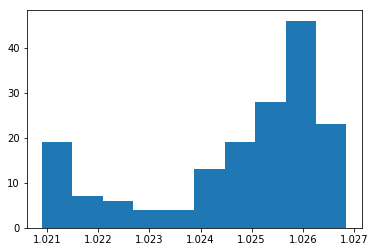

In [725]:
plt.hist(np.asarray(alpha_jk))

In [709]:
alpha_jk[:,0].shape

TypeError: list indices must be integers or slices, not tuple

In [710]:
np.sum(weight_jk)

1.0000000000000646

In [689]:
alpha_jk.shape

AttributeError: 'list' object has no attribute 'shape'

In [692]:
np.sum(weight_jk*alpha_jk)/np.sum(weight_jk)

172.25332031249997

In [711]:
#alpha_jk_file=np.load('/mnt/store1/oliverphilcox/DR12_QPM/single_mock_jackknife_alpha_simple.npz')
#alpha_jk = alpha_jk_file['alpha'][:,0]
alpha_jk = np.asarray(alpha_jk)[:,0]
weight_jk = np.asarray(w_A_jk)
#weight_jk = alpha_jk_file['weights']
#weight_jk/=np.sum(weight_jk)
weight_noA = 1.-weight_jk
weight_noA/=np.sum(weight_noA)

mean_a = np.sum(weight_jk*alpha_jk)/np.sum(weight_jk)

alpha_jk_error = np.sqrt(np.sum((1.-weight_jk)**2.*(alpha_jk-mean_a)**2.)/(1.-np.sum(weight_jk**2.)))
print("%.4f"%alpha_jk_error)

0.0242


In [712]:
np.sqrt(np.sum((1.-weight_jk)*(alpha_jk-mean_a)**2.))

0.024096276155610847

In [713]:
np.sum(1.-weight_jk)

167.99999999999994

In [714]:
np.std(alpha_jk)

0.0017068189075006947

In [715]:
np.sqrt(np.sum(weight_jk*(alpha_jk-mean_a)**2.))

0.0009317349513047945

(array([20., 43., 38., 20.,  7.,  2.,  6.,  7.,  7., 19.]),
 array([-0.00136545, -0.00078928, -0.00021311,  0.00036306,  0.00093923,
         0.0015154 ,  0.00209158,  0.00266775,  0.00324392,  0.00382009,
         0.00439626]),
 <a list of 10 Patch objects>)

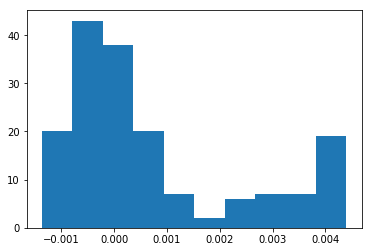

In [716]:
plt.hist(mean_a-alpha_jk)

In [737]:
print("Loading QPM covariance matrix")
qpm_dat = np.load('/mnt/store1/oliverphilcox/qpm_900_mock_covariance.npz')
qpm_cov = qpm_dat['cov']
qpm_prec=np.linalg.inv(qpm_dat['cov'])*(1.-(len(qpm_cov)+1.)/899.)

Loading QPM covariance matrix


In [738]:
# Now optimize for shot-noise rescaling parameter alpha
print("Optimizing for the shot-noise rescaling parameter")
from scipy.optimize import fmin
alpha_best = fmin(neg_log_L1,1.)
print("Optimization complete - optimal rescaling parameter is %.6f"%alpha_best)

Optimizing for the shot-noise rescaling parameter
Optimization terminated successfully.
         Current function value: -4567.895692
         Iterations: 10
         Function evaluations: 20
Optimization complete - optimal rescaling parameter is 1.031641


In [739]:
# Load in full theoretical matrix
c2f,c3f,c4f=load_matrices('full',jack=False)

# Load in partial full theoretical matrices
c2fs,c3fs,c4fs=[],[],[]
for i in range(n_samples):
    #print("Loading full subsample %d of %d"%(i+1,n_samples))
    cc2,cc3,cc4=load_matrices(i,jack=False)
    c2fs.append(cc2)
    c3fs.append(cc3)
    c4fs.append(cc4)

# Compute inverted matrix
def Psi_full(alpha,return_neff=False):
    """Compute precision matrix from covariance matrix, removing quadratic order bias terms."""
    cf_tot = c2f*alpha**2.+c3f*alpha+c4f
    partial_cov=[]
    for i in range(n_samples):
        partial_cov.append(alpha**2.*c2fs[i]+alpha*c3fs[i]+c4fs[i])
    tmp=0.
    for i in range(n_samples):
        c_excl_i = np.mean(partial_cov[:i]+partial_cov[i+1:],axis=0)
        tmp+=np.matmul(np.linalg.inv(c_excl_i),partial_cov[i])
    D_est=(n_samples-1.)/n_samples * (-1.*np.eye(n_bins) + tmp/n_samples)
    Psi = np.matmul(np.eye(n_bins)-D_est,np.linalg.inv(cf_tot))
    if return_neff:
        slogD = np.linalg.slogdet(D_est)
        D_val = slogD[0]*np.exp(slogD[1]/n_bins)
        n_eff = (n_bins+1.)/D_val+1
        return Psi,n_eff
    return Psi

def neg_log_L1_full(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    Psi_alpha = Psi_full(alpha)
    logdet = np.linalg.slogdet(Psi_alpha)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_alpha,qpm_cov))-logdet[1]

def neg_log_L2_full(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    cov = c2f*alpha**2.+c3f*alpha+c4f
    Psi_dat = qpm_prec#np.linalg.inv(qpm_cov)
    logdet = np.linalg.slogdet(cov)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_dat,cov))-logdet[1]

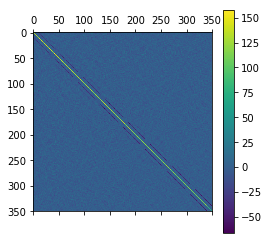

In [740]:
plt.matshow(qpm_prec/r_matrix);plt.colorbar()

Now get jackknife errors on the full $\alpha$ by leaving out mocks

In [741]:
qpm_jk_cov = np.load('/mnt/store1/oliverphilcox/DR12_QPM/qpm_900_jackknife_mocks.npy')

In [742]:
alpha_full_jk=[]
for m,mock in enumerate(qpm_jk_cov):
    if m%10==0:
        print(m)
    def neg_log_L1_full_quick(alpha):
        """Return negative log L1 likelihood between data and theory covariance matrices"""
        Psi_alpha = np.linalg.inv(c2f*alpha**2.+c3f*alpha+c4f)
        logdet = np.linalg.slogdet(Psi_alpha)
        if logdet[0]<0:
            # Remove any dodgy inversions
            return np.inf        
        return np.trace(np.matmul(Psi_alpha,mock))-logdet[1]

    alpha_full_jk.append(fmin(neg_log_L1_full_quick,1.))

0
Optimization terminated successfully.
         Current function value: -4467.216763
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.275994
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.267697
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.247287
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.241795
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.234398
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.239393
         Iterations: 10
         Function evaluations: 20
Opti

Optimization terminated successfully.
         Current function value: -4467.254001
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.291875
         Iterations: 10
         Function evaluations: 20
60
Optimization terminated successfully.
         Current function value: -4467.252248
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.268783
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.227235
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.216464
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.215573
         Iterations: 10
         Function evaluations: 20
Opt

Optimization terminated successfully.
         Current function value: -4467.247741
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.261793
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.220063
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.248268
         Iterations: 10
         Function evaluations: 20
120
Optimization terminated successfully.
         Current function value: -4467.235467
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.261457
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.266815
         Iterations: 10
         Function evaluations: 20
Op

Optimization terminated successfully.
         Current function value: -4467.254748
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.237280
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.246430
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.234734
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.203268
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.240282
         Iterations: 10
         Function evaluations: 20
180
Optimization terminated successfully.
         Current function value: -4467.258154
         Iterations: 10
         Function evaluations: 20
Op

Optimization terminated successfully.
         Current function value: -4467.307325
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.286525
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.254728
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.226140
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.268874
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.283890
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.212074
         Iterations: 10
         Function evaluations: 20
Optimi

Optimization terminated successfully.
         Current function value: -4467.208953
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.259081
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.255470
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.279722
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.254878
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.253665
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.246531
         Iterations: 10
         Function evaluations: 20
Optimi

Optimization terminated successfully.
         Current function value: -4467.257861
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.261684
         Iterations: 10
         Function evaluations: 20
350
Optimization terminated successfully.
         Current function value: -4467.266717
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.226644
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.217239
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.243451
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.303522
         Iterations: 10
         Function evaluations: 20
Op

Optimization terminated successfully.
         Current function value: -4467.232808
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.273100
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.300012
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.267026
         Iterations: 10
         Function evaluations: 20
410
Optimization terminated successfully.
         Current function value: -4467.230268
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.275031
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.243746
         Iterations: 10
         Function evaluations: 20
Op

Optimization terminated successfully.
         Current function value: -4467.230201
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.247725
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.214724
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.241915
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.264851
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.231483
         Iterations: 10
         Function evaluations: 20
470
Optimization terminated successfully.
         Current function value: -4467.246307
         Iterations: 10
         Function evaluations: 20
Op

Optimization terminated successfully.
         Current function value: -4467.287770
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.222385
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.235113
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.233278
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.230686
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.249809
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.255945
         Iterations: 10
         Function evaluations: 20
Optimi

Optimization terminated successfully.
         Current function value: -4467.208802
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.211091
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.175088
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.251952
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.258287
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.204366
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.275217
         Iterations: 10
         Function evaluations: 20
Optimi

Optimization terminated successfully.
         Current function value: -4467.245067
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.229731
         Iterations: 10
         Function evaluations: 20
640
Optimization terminated successfully.
         Current function value: -4467.225008
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.244916
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.218962
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.223234
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.207728
         Iterations: 10
         Function evaluations: 20
Op

Optimization terminated successfully.
         Current function value: -4467.276323
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.253541
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.228459
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.289088
         Iterations: 10
         Function evaluations: 20
700
Optimization terminated successfully.
         Current function value: -4467.223890
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.223459
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.218869
         Iterations: 10
         Function evaluations: 20
Op

Optimization terminated successfully.
         Current function value: -4467.208649
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.268233
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.232446
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.273486
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.281138
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.241269
         Iterations: 10
         Function evaluations: 20
760
Optimization terminated successfully.
         Current function value: -4467.286833
         Iterations: 10
         Function evaluations: 20
Op

Optimization terminated successfully.
         Current function value: -4467.221189
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.253952
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.243877
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.257335
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.223343
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.235778
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.239570
         Iterations: 10
         Function evaluations: 20
Optimi

Optimization terminated successfully.
         Current function value: -4467.262502
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.240829
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.232404
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.194159
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.242182
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.207328
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: -4467.210195
         Iterations: 10
         Function evaluations: 20
Optimi

In [743]:
mean_alpha_jk = np.mean(alpha_full_jk)

In [744]:
std_alpha_jk=np.sqrt(np.sum((np.asarray(alpha_full_jk)-mean_alpha_jk)**2.)/len(alpha_full_jk)*(len(alpha_full_jk)-1.))

In [745]:
np.std(alpha_full_jk)*np.sqrt(900)

0.001929816979147017

In [746]:
print("%.4f"%std_alpha_jk)

0.0019


(array([ 55.,   0.,   0., 441.,   0.,   0., 380.,   0.,   0.,  24.]),
 array([1.02080078, 1.02083008, 1.02085937, 1.02088867, 1.02091797,
        1.02094727, 1.02097656, 1.02100586, 1.02103516, 1.02106445,
        1.02109375]),
 <a list of 10 Patch objects>)

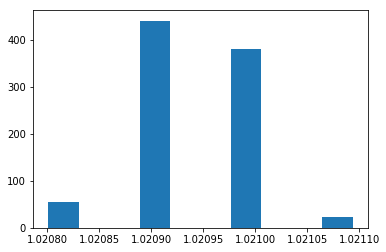

In [624]:
plt.hist(np.asarray(alpha_full_jk))

## Plot 2,3,4 point matrix terms

In [850]:
cov_root=file_root+'CovMatricesJack/'
index='full'
EEaA1 = np.loadtxt(cov_root+'EE1_n%d_m%d_11_%s.txt' %(n,m,index))
EEaA2 = np.loadtxt(cov_root+'EE2_n%d_m%d_11_%s.txt' %(n,m,index))
RRaA1 = np.loadtxt(cov_root+'RR1_n%d_m%d_11_%s.txt' %(n,m,index))
RRaA2 = np.loadtxt(cov_root+'RR2_n%d_m%d_11_%s.txt' %(n,m,index))

# Compute disconnected term
w_aA1 = RRaA1/np.sum(RRaA1,axis=0)
w_aA2 = RRaA2/np.sum(RRaA2,axis=0)
diff1 = EEaA1-w_aA1*EEaA1.sum(axis=0)
diff2 = EEaA2-w_aA2*EEaA2.sum(axis=0)
RRaRRb = np.matmul(np.asmatrix(RR).T,np.asmatrix(RR))
fact = np.ones_like(c4)-np.matmul(np.asmatrix(weights).T,np.asmatrix(weights))
cx = np.asarray(np.matmul(diff1.T,diff2)/np.matmul(fact,RRaRRb))

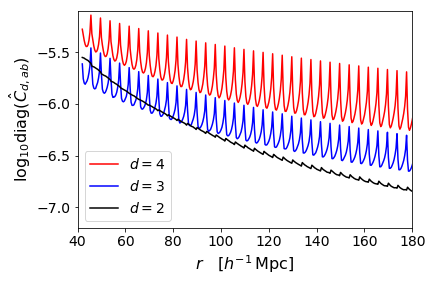

In [845]:
fig=plt.figure()
r_co = np.arange(min(all_r),max(all_r)+4.,0.4)
plt.plot(r_co,np.log10(np.diag(c4f)),c='r',label=r'$d=4$')
plt.plot(r_co,np.log10(np.diag(c3f)),c='b',label=r'$d=3$')
plt.plot(r_co,np.log10(np.diag(c2f)),c='k',label=r'$d=2$')
plt.legend(fontsize=14)
plt.xlim([40,180])
plt.ylim([-7.2,-5.1])
plt.xlabel(r'$r\quad [h^{-1}\,\mathrm{Mpc}]$',fontsize=16)
plt.ylabel(r'$\log_{10}\mathrm{diag}(\hat C_{d,ab})$',fontsize=16)
plt.gca().xaxis.set_tick_params(which='both',labelsize=14)
plt.gca().yaxis.set_tick_params(which='both',labelsize=14)
plt.savefig('/home/oliverphilcox/COMAJE/plots/new/diag_full.pdf',bbox_inches='tight')

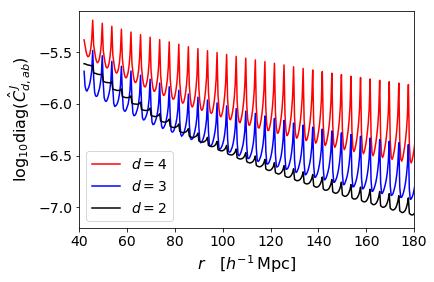

In [856]:
fig=plt.figure()
r_co = np.arange(min(all_r),max(all_r)+4.,0.4)
plt.plot(r_co,np.log10(np.diag(c4-cx)),c='r',label=r'$d=4$')
plt.plot(r_co,np.log10(np.diag(c3)),c='b',label=r'$d=3$')
plt.plot(r_co,np.log10(np.diag(c2)),c='k',label=r'$d=2$')
plt.legend(fontsize=14)
plt.xlim([40,180])
plt.ylim([-7.2,-5.1])
plt.xlabel(r'$r\quad [h^{-1}\,\mathrm{Mpc}]$',fontsize=16)
plt.ylabel(r'$\log_{10}\mathrm{diag}(\hat{C}^{\,J}_{d,ab})$',fontsize=16)
plt.gca().xaxis.set_tick_params(which='both',labelsize=14)
plt.gca().yaxis.set_tick_params(which='both',labelsize=14)
plt.savefig('/home/oliverphilcox/COMAJE/plots/new/diag_jack.pdf',bbox_inches='tight')

### Plot Precision Matrices for Mock + QPM + Difference

In [391]:
np.where(all_r==114.)

(array([180, 181, 182, 183, 184, 185, 186, 187, 188, 189]),)

In [747]:
FS=18
from mpl_toolkits.axes_grid1 import make_axes_locatable
def prec_plot(mat,title="",FS=16,vmax=0):
    if vmax==0:
        vmax = max(mat.ravel())
    im=plt.matshow(mat,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax);
    plt.xlim([150,190])
    plt.ylim([190,150]);
    plt.xlabel(r'Bin $a$',fontsize=FS)
    plt.ylabel(r'Bin $b$',fontsize=FS)
    #if len(title)>0:
    #    plt.title(title,fontsize=FS)
    plt.gca().grid(True)
    plt.tick_params(axis='both',length=0,which='both')
    plt.gca().xaxis.set_ticks_position('bottom')
    for ax in [plt.gca().xaxis,plt.gca().yaxis]:
        ax.set_major_locator(plt.MaxNLocator(4))
        ax.set_minor_locator(plt.MaxNLocator(9))
        ax.set_ticklabels(["",102,"",106,"",110,"",114,""],minor=True)
        ax.set_ticklabels([""])
        ax.set_tick_params(which='both',labelsize=14)
    # Add colorbar
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.0)
    plt.colorbar(im, cax=cax)
    
    # We change the fontsize of minor ticks label 
    plt.gca().tick_params(axis='both', which='major', labelsize=14)
    
    return plt.gcf()

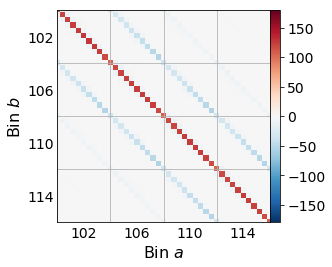

In [753]:
mat = Psi_full(alpha_best)/r_matrix
fig=prec_plot(mat,title = r"$\hat\Psi_{ab}$ (Model)",vmax=180)
plt.savefig("/home/oliverphilcox/COMAJE/plots/new/SingleMockPrec.pdf",bbox_inches='tight')

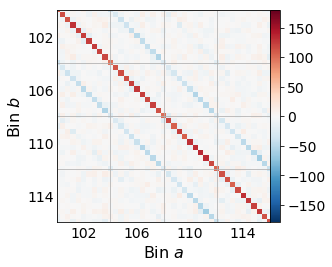

In [754]:
fig=prec_plot(qpm_prec/r_matrix,title = r"$\hat\Psi_{ab}$ (Mocks)",vmax=180)
plt.savefig("/home/oliverphilcox/COMAJE/plots/new/QPMPrec.pdf",bbox_inches='tight')

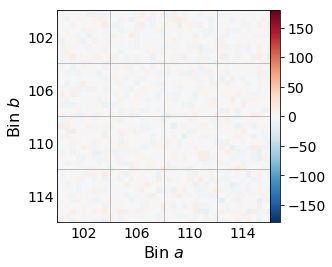

In [755]:
fig=prec_plot(qpm_prec/r_matrix-Psi_full(alpha_best)/r_matrix,title = r"Mocks - Model",vmax=180)
plt.savefig("/home/oliverphilcox/COMAJE/plots/new/SingleMockQPMDiff.pdf",bbox_inches='tight')

In [782]:
def residuals(matrix,prec=False):
    r_bins = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/radial_binning_cov.csv').mean(axis=1)
    n=len(r_bins)
    m=len(qpm_cov)//n
    mu_bins_tmp = np.linspace(0.,1.,m+1)
    mu_bins = np.mean([mu_bins_tmp[1:],mu_bins_tmp[:-1]],axis=0)
    r_bins_all = np.concatenate([[r_bins[i] for _ in range(m)] for i in range(len(r_bins))])
    mu_bins_all = np.hstack([mu_bins for _ in range(len(r_bins))])
    r_matrix = np.matmul(np.asmatrix(r_bins_all).T,np.asmatrix(r_bins_all))
    
    if prec:
        resid=matrix/r_matrix
    else:
        resid=matrix*r_matrix
    
    r_diff = []
    for rr in r_bins:
        for rr2 in r_bins:
            r_diff.append(rr-rr2)
    r_diff = np.unique(np.asarray(r_diff).round(8)) # remove rounding errors
    mu_diff = []
    for mu in mu_bins:
        for mu2 in mu_bins:
            mu_diff.append(mu-mu2)
    mu_diff = np.unique(np.asarray(mu_diff).round(8)) # remove rounding errors

    mu_edge = np.linspace(-1,1,len(mu_diff)+1)
    delta_r = r_diff[1]-r_diff[0]
    r_edge = np.arange(min(r_diff)-delta_r/2.,max(r_diff)+3.*delta_r/2.,delta_r)
    mu_edges = np.vstack([mu_edge for _ in range(len(r_edge))])
    r_edges = np.vstack([r_edge for _ in range(len(mu_edge))])

    stacked_resid = np.zeros([len(mu_diff),len(r_diff)])
    denom = np.zeros([len(mu_diff),len(r_diff)])
    for i in range(len(resid)):
        for j in range(resid.shape[1]):
            r_index = np.where((r_bins_all[i]-r_bins_all[j]).round(3)==r_diff.round(3))
            mu_index = np.where((mu_bins_all[i]-mu_bins_all[j]).round(4)==mu_diff.round(4))
            stacked_resid[mu_index,r_index]=resid[i,j]
            denom[mu_index,r_index]+=1
    stacked_resid=np.divide(stacked_resid,denom)
    return r_edges,mu_edges,stacked_resid

def resid_plot(resid_data,vmax=0.5,title='',cbar_title="",FS=16,return_fig=False):
    r_edges,mu_edges,stacked_resid=resid_data
    plt.pcolor(mu_edges.T,r_edges,stacked_resid,cmap=cm.RdBu_r,vmax=vmax,vmin=-vmax)
    plt.ylim([-30,30]);
    plt.xlim([-0.5,0.5])
    cbar=plt.colorbar();FS=16
    plt.gca().xaxis.set_tick_params(which='both',labelsize=FS-2)
    plt.gca().yaxis.set_tick_params(which='both',labelsize=FS-2)
    if len(cbar_title)>0:
        cbar.set_label(cbar_title,fontsize=FS)
    plt.ylabel(r'$\Delta\,r \quad [h^{-1}\,Mpc]$',fontsize=FS);plt.xlabel(r'$\Delta\,\mu$',fontsize=FS);
    if len(title)>0:
        plt.title(title,fontsize=FS-2)
    if return_fig:
        return plt.gcf()

In [788]:
resid_data=residuals(qpm_prec-Psi_full(0.996),prec=True)

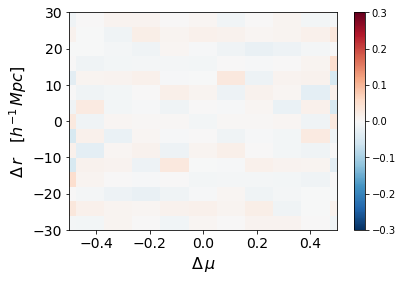

In [789]:
resid_plot(resid_data,vmax=0.3)

In [785]:
resid_data2 = residuals(qpm_prec-Psi_full(alpha_best),prec=True)

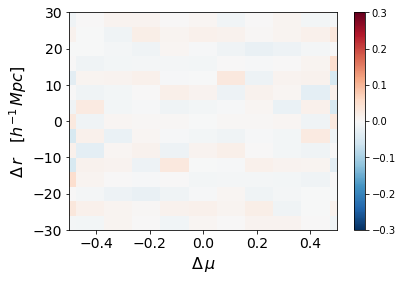

In [786]:
fig=resid_plot(resid_data2,vmax=0.3,return_fig=True,FS=16)

In [551]:
fig.savefig("/home/oliverphilcox/COMAJE/plots/new/SingleQPMStackedResid.pdf",bbox_inches='tight')

Compute KL divergence between mock + model

In [552]:
prec = Psi_full(alpha_best)

In [556]:
slog1=np.linalg.slogdet(prec)
slog2=np.linalg.slogdet(qpm_cov)
true_KL=0.5*(np.trace(np.matmul(qpm_cov,prec))-slog1[1]-slog2[1]-len(prec))
print(true_KL)

40.11394331137353


In [557]:
n_bins = len(prec)
expect_KL=n_bins*(1.+n_bins)/(4.*1000)

In [558]:
expect_KL

30.7125

In [336]:
from scipy.optimize import fmin
alpha_best_full_L2 = fmin(neg_log_L2_full,1.)
print("L2 Optimization complete - optimal rescaling parameter is %.6f"%alpha_best_full_L2)

Optimization terminated successfully.
         Current function value: 5156.605408
         Iterations: 10
         Function evaluations: 20
L2 Optimization complete - optimal rescaling parameter is 1.042871


In [337]:
from scipy.optimize import fmin
alpha_best_full = fmin(neg_log_L1_full,1.)
print("Optimization complete - optimal rescaling parameter is %.6f"%alpha_best_full)

Optimization terminated successfully.
         Current function value: -4455.459307
         Iterations: 10
         Function evaluations: 20
Optimization complete - optimal rescaling parameter is 1.044824


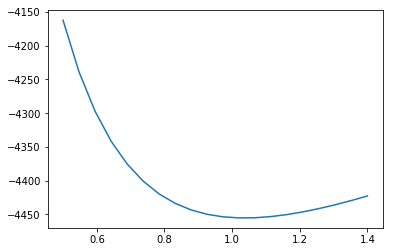

In [221]:
alphas = np.linspace(0.5,1.4,20)
likes = [neg_log_L1_full(a) for a in alphas]
plt.plot(alphas,likes)

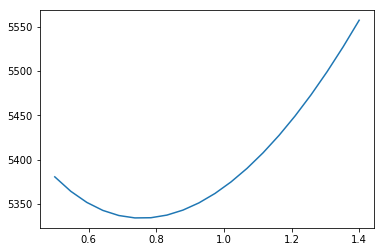

In [222]:
alphas = np.linspace(0.5,1.4,20)
likes = [neg_log_L2_full(a) for a in alphas]
plt.plot(alphas,likes)

In [223]:
def neg_log_L2_full_rascal(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    cov = c2r*alpha**2.+c3r*alpha+c4r
    Psi_dat = np.linalg.inv(qpm_cov)
    logdet = np.linalg.slogdet(cov)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_dat,cov))-logdet[1]

In [224]:
fmin(neg_log_L2_full_rascal,1.)

Optimization terminated successfully.
         Current function value: 5339.343460
         Iterations: 13
         Function evaluations: 26


array([0.79003906])

In [225]:
def neg_log_L1_full_rascal(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    Psi_alpha = np.linalg.inv(c2r*alpha**2+c3r*alpha+c4r)#Psi_full(alpha)
    logdet = np.linalg.slogdet(Psi_alpha)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_alpha,qpm_cov))-logdet[1]

fmin(neg_log_L1_full_rascal,1.)

Optimization terminated successfully.
         Current function value: -4453.495179
         Iterations: 10
         Function evaluations: 20


array([1.06894531])

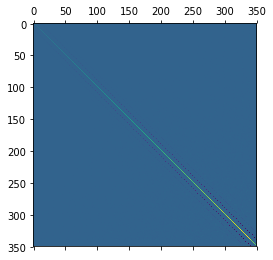

In [148]:
plt.matshow(Psi_full(0.8));

## load in Rascal matrices

In [50]:
import pickle
rascal_run = pickle.load(open('/mnt/store1/oliverphilcox/LowR__mean.pkl',"rb"),encoding='latin1')

In [56]:
c2r=rascal_run['c2'][100:,100:]
c3r=rascal_run['c3'][100:,100:]
c4r=rascal_run['c4'][100:,100:]

In [64]:
r_bins = np.loadtxt('/mnt/store1/oliverphilcox/DR12_QPM/radial_binning_cov.csv').mean(axis=1)
mu_bins = np.arange(0.05,1.05,0.1)

all_r = np.asarray([r_bins[i//10] for i in range(len(c2r))])
r_matrix = np.matmul(all_r.reshape(-1,1),all_r.reshape(1,-1))

In [117]:
prec = lambda alpha: np.linalg.inv(c2r*alpha**2.+c3r*alpha+c4r)
cov = lambda alpha: c2r*alpha**2.+c3r*alpha+c4r
my_cov = lambda alpha: c2f*alpha**2.+c3f*alpha+c4f

In [95]:
def prec_plot(matrix,vmax=250):
    plt.matshow(matrix/r_matrix,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
    plt.colorbar();plt.ylim([190,150]);plt.xlim([150,190]);
def cov_plot(matrix,vmax=0.001):
    plt.matshow(matrix*r_matrix,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
    plt.colorbar();plt.ylim([190,150]);plt.xlim([150,190]);

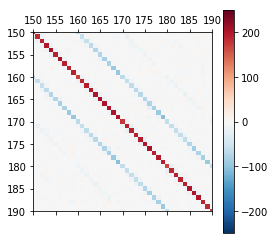

In [84]:
prec_plot(prec(0.8))

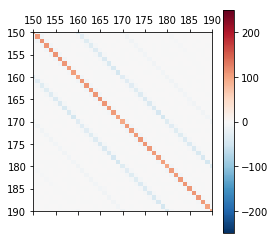

In [83]:
prec_plot(Psi_full(1.1))

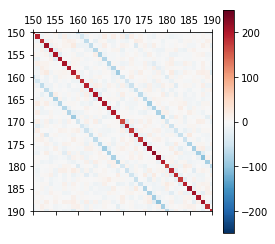

In [96]:
prec_plot(qpm_prec)

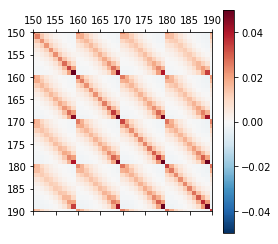

In [101]:
cov_plot(cov(1.),vmax=0.05)

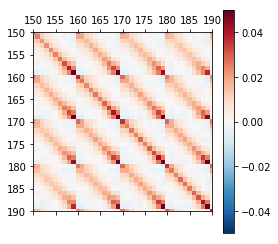

In [118]:
cov_plot(qpm_cov,vmax=0.05)

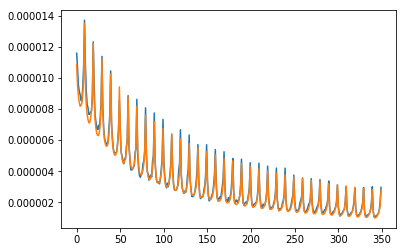

In [126]:
plt.plot(np.diag(qpm_cov))
plt.plot(np.diag(cov(1.04)))
#plt.plot(np.diag(my_cov(1.04)))

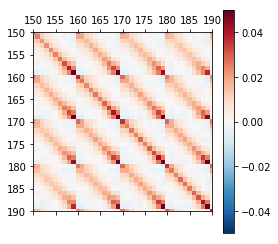

In [127]:
cov_plot(qpm_cov,vmax=0.05)

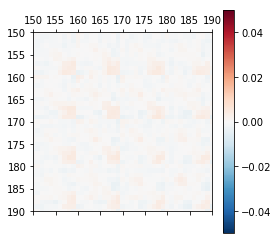

In [128]:
cov_plot(qpm_cov-my_cov(alpha_best_full),vmax=0.05)

Check precision matrices from subruns - is this a convergence issue?

In [177]:
cov_subrun = lambda alpha: c2fs[0]*alpha**2.+c3fs[0]*alpha+c4fs[0]
mean_cov = lambda alpha: np.mean(np.asarray(c2fs)*alpha**2.+np.asarray(c3fs)*alpha+np.asarray(c4fs),axis=0)
mean_prec = lambda alpha: np.linalg.inv(mean_cov(alpha))
prec_subrun = lambda alpha: np.linalg.inv(cov_subrun(alpha))

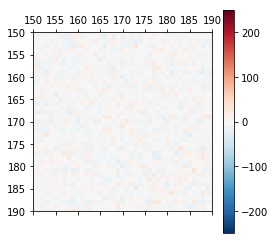

In [212]:
prec_plot(prec(0.8)-qpm_prec)

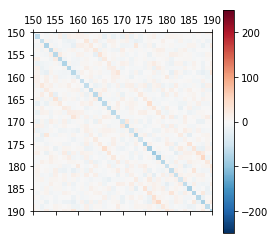

In [213]:
prec_plot(prec(1.)-qpm_prec)

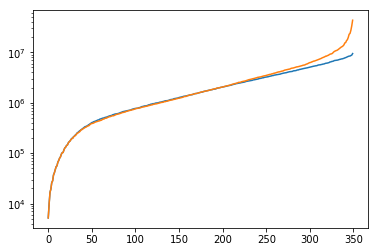

In [186]:
plt.plot(np.linalg.eigvalsh(mean_prec(0.8)))
plt.plot(np.linalg.eigvalsh(prec_subrun(0.8)))
plt.yscale('log')

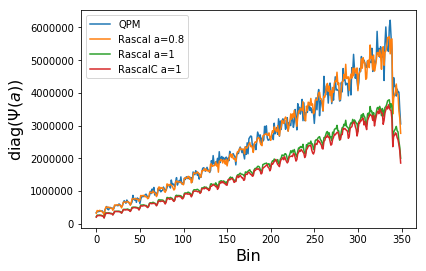

In [91]:
plt.plot(np.diag(qpm_prec),label='QPM')
plt.plot(np.diag(prec(0.8)),label='Rascal a=0.8')
plt.plot(np.diag(prec(1.)),label='Rascal a=1')
plt.plot(np.diag(Psi_full(1.)),label='RascalC a=1');
plt.legend()
plt.ylabel('$\mathrm{diag}(\Psi(a))$',fontsize=16)
plt.xlabel('Bin',fontsize=16);

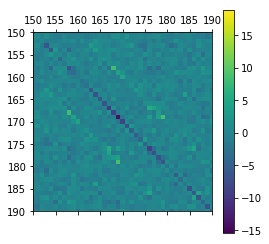

In [67]:
plt.matshow((Psi_full(1.)-prec(1.))/r_matrix);plt.colorbar();plt.ylim([190,150]);plt.xlim([150,190]);